In [2]:
import mmf_setup;mmf_setup.nbinit()
%pylab inline
import pandas as pd


%load_ext autoreload
import sys;sys.path.append('../')

<IPython.core.display.Javascript object>

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Matching Pursuit

We start with a simple polynomial fitting demonstration.  This shows that the regular matching-pursuit algorithm does not do a very good job, but that the orthogonal version can complete the fit.

In [3]:
%autoreload
from cycles.cycles import matching_pursuit, orthogonal_matching_pursuit


class MatchPoly(object):
    """Simple "polynomial" matching over [0,1]."""

    x = np.linspace(0, 1, 100)
    powers = np.linspace(0, 100, 1000)
    powers = np.arange(4)

    def __init__(self, **kw):
        self.__dict__.update(kw)
        self.D = self.x[:, np.newaxis] ** self.powers[np.newaxis, :]

        # Normalize and keep track of norms for extrapolators
        self.norms = np.linalg.norm(self.D, axis=0)
        self.D /= self.norms

    def __call__(self, s):
        a_ = s @ self.D
        i = np.argmax(abs(a_))
        d = self.D[:, i]
        a = a_[i]
        f = self.powers[i]
        A = 1/self.norms[i]
        return (d, a, (A, f))

match = MatchPoly()
x = match.x

s = np.sin(2*x)
D, a, f, r = matching_pursuit(s, match=match, rtol=0.001, max_rank=6)
plt.plot(x, s)
plt.plot(x, D @ a, '--')

D1, a1, f1, r1 = orthogonal_matching_pursuit(s, match=match, rtol=0.001, max_rank=6)
plt.plot(x, D1 @ a1, '--')



from sympy import S
x_ = S('x')
A, p = map(np.array, zip(*f))
A1, p1 = map(np.array, zip(*f1))
display((a * A) @ np.power(S('x'), p))
display((a1 * A1) @ np.power(S('x'), p1))
P = np.polyfit(x, s, deg=3)
display(np.polyval(P, x_).expand())
plt.plot(x, np.polyval(P, x), ':')

TypeError: matching_pursuit() missing 2 required positional arguments: 'D0' and 'ws'

# Moab Temperatures

In this notebook, we look for cycles in the temperature of Arches National Park near Moab UT, orderd from [NOAA](https://www.ncdc.noaa.gov/cdo-web/datasets)

```
ORDER ID: #2478833
https://www.ncdc.noaa.gov/cdo-web/orders?email=michael.forbes@gmail.com&id=2478833
Stations	
GHCND:USC00420336
Begin Date	1980-06-01 00:00
End Date	2021-01-29 23:59
Data Types	
TMAX TMIN TOBS
Units	
Metric
Custom Flag(s)	
Station Name
Eligible for Certification	No
```

# Read the data

In [32]:
%pylab inline
import pandas as pd

datafile = '2478833.csv'
data = pd.read_csv(datafile, quotechar='"', parse_dates=[2])
#data.DATE

Populating the interactive namespace from numpy and matplotlib


# Add ```year```, ``day_of_year`` to data

In [0]:
day_of_year = np.array([_d.dayofyear for _d in data.DATE])
data["day_of_year"] = day_of_year
data['year'] = data.DATE.dt.year
years = np.array([_d.year for _d in data.DATE])

# set figure parameters

In [34]:
size = 15
title_FontSize = 10
legend_FontSize = 8
tick_FontSize = 12
label_FontSize = 14

params = {'legend.fontsize': 'large',
          'figure.figsize': (6, 4),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size * 0.75,
          'ytick.labelsize': size * 0.75,
          'axes.titlepad': 10}


#
#  Once set, you cannot change them, unless restart the notebook
#
plt.rc('font', family = 'palatino')
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update(params)
# pylab.rcParams.update(params)
plt.rc('text', usetex=True)

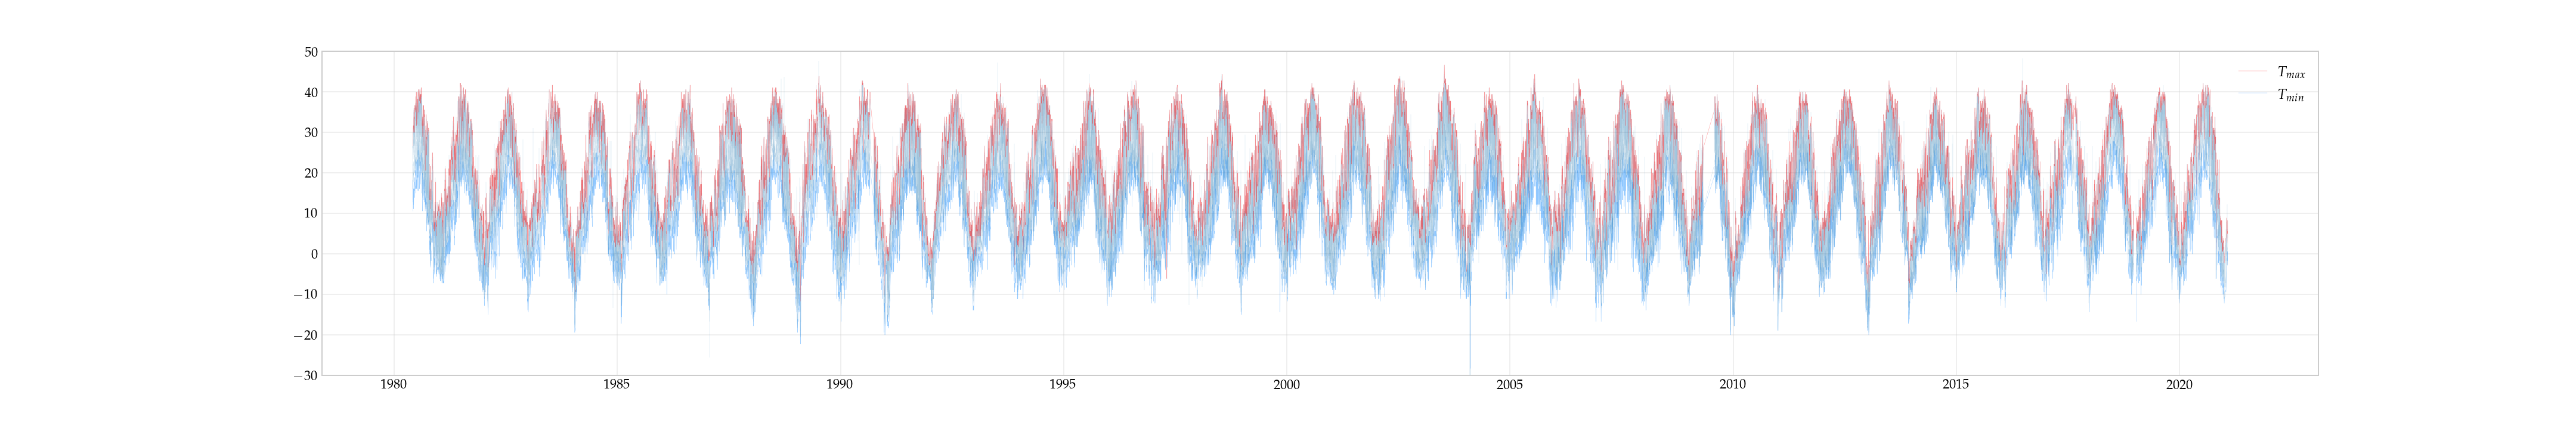

In [39]:
plt.figure(figsize=(30,5))
plt.errorbar(data.DATE, data.TOBS, yerr=[data.TMIN-data.TOBS, data.TMAX-data.TOBS], lw=0.1, alpha=0.5)
plt.plot(data.DATE, data.TMAX, lw=0.2, alpha=0.5, label = r'$T_{max}$', c="red")
plt.plot(data.DATE, data.TMIN, lw=0.2, alpha=0.5, label = r'$T_{min}$', c="dodgerblue") # blue for cold

plt.legend(loc="upper right");
plt.ylim([-30, 50]);
# plt.xlim([1981, 2020]);

# Get rid of first and last year since thet are incomplete

In [41]:
data.drop(data[data['year'] == min(years)].index, inplace = True)
data.drop(data[data['year'] == max(years)].index, inplace = True)
mask = np.ma.masked_invalid(data.TMIN).mask

In [42]:
data.head(2)

,STATION,NAME,DATE,TMAX,TMIN,TOBS,day_of_year,year
214,USC00420336,"ARCHES NATIONAL PARK HQS, UT US",1981-01-01,11.1,-5.0,-4.4,1,1981
215,USC00420336,"ARCHES NATIONAL PARK HQS, UT US",1981-01-02,10.0,-4.4,-2.2,2,1981


# Fix the 2009 data here

In [43]:
data_2009 = data[data.year == 2009].copy()
data_2009_full = pd.DataFrame(data=None, index=np.arange(365), columns=['day_of_year'], dtype=None)
data_2009_full['day_of_year'] = np.arange(1, 366)
data_2009_full = pd.merge(data_2009_full, data_2009, how="left", on="day_of_year")
data_2009_full['year'] = 2009

In [66]:
(data_2009_full.DATE[1] - data_2009_full.DATE[0]).days

1

In [63]:
type(data_2009_full.DATE[1])

pandas._libs.tslibs.timestamps.Timestamp

In [45]:
# data_2009_full['year'] = 2009
# data_2009_full[100:200]

# add DATE for missing days in the origial data

In [46]:
data_2009_full.day_of_year = data_2009_full.day_of_year.astype(int)
data_2009_full['DATE'] = pd.to_datetime(data_2009_full['year']* 1000 + data_2009_full['day_of_year'], format='%Y%j')

# Filter out 2009 and then add it back in.

In [48]:
data = data[data.year != 2009].copy()
data.reset_index(drop=True, inplace=True)

In [51]:
data = pd.concat([data, data_2009_full])
data.reset_index(drop=True, inplace=True)

This is not a very nice way of looking at the data.  Let's try something else that removes the overall 365 day cycle.

In [18]:
# plt.figure(figsize=(1,10))
# day_of_year = np.array([_d.dayofyear for _d in data.DATE])
# years = np.array([_d.year for _d in data.DATE])
# for year in set(years):
#     print(year)
#     inds = (data[data.DATE == year])
#     plt.plot(data.day_of_year[inds], (data.TMAX + year*50)[inds], '-')

<Figure size 640x480 with 0 Axes>

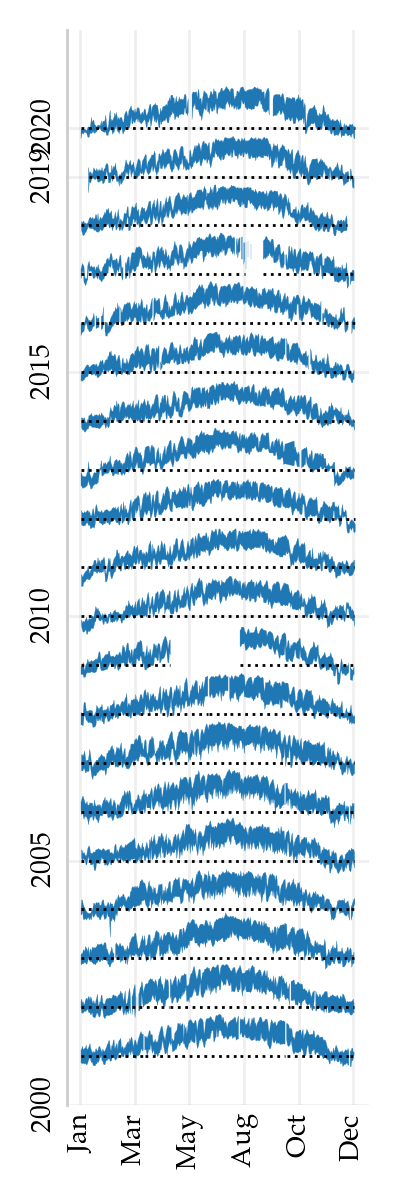

In [52]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400
mpl.rcdefaults()
plt.style.use('Figures/tufte.mplstyle')
#plt.rcParams['text.usetex'] = False
#plt.rc('font', family='Palatino')

plt.subplots_adjust(right=1.5, top=1.1)
pt_per_inch = 72.27
marginwidth_inch = 144.0/pt_per_inch
textheight = 616.0/pt_per_inch
##########################################################################################
#fig, axs = plt.subplots(1, 1, figsize=(marginwidth_inch, 6),
#                        sharex='col', sharey='row',
#                        gridspec_kw={'hspace': 0.2, 'wspace': .1});
fig = plt.figure(figsize=(marginwidth_inch, 6))
ax = plt.subplot(111)

ax.tick_params(axis='y', which='major')
ax.tick_params(axis='x', which='major')


T_fact = 0.02
years_to_display = 21
yrs = np.array(sorted(set(years))[-years_to_display:])
for n, year in enumerate(yrs):
    current_year = data[data.DATE.dt.year == year]
    _mask = np.ma.masked_invalid(current_year.TMIN).mask

    ax.fill_between(np.ma.MaskedArray(current_year.day_of_year, mask=_mask),
                    np.ma.MaskedArray(current_year.TMIN*T_fact + year, mask=_mask),
                    np.ma.MaskedArray(current_year.TMAX*T_fact + year, mask=_mask),
                    lw=0.1, color='C0')
    ax.plot(current_year.day_of_year, 0*current_year.TMIN + year, ':k', lw=1)
for _s in ax.spines:
    if _s == 'left':
        continue
    ax.spines[_s].set_visible(False)


from matplotlib import dates as mdates
fmt_month = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(fmt_month)
ax.set(ylim=[yrs.min()-1, yrs.max()+1])
plt.yticks(np.arange(((yrs.min())/5).round(0) * 5, yrs.max(), 5).tolist() + [2019],
           va='center', rotation=90)
plt.xticks(np.linspace(0, 364, 6), rotation=90)
plt.tight_layout()

# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()

# plot_dir = ""
# file_name = plot_dir + "dailyTemp.pdf"
# plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)

In [56]:
type(data.day_of_year.values)

numpy.ndarray

In [20]:
from matplotlib import dates as mdates
class MyDateFormatter(mdates.DateFormatter):
    """Hack to get correct data from theta."""
    def date_to_theta(self, data):
        return 2*np.pi * (data - self.T0)/self.T

    def theta_to_date(self, theta):
        return self.T0 + self.T * np.asarray(theta) / (2*np.pi)

    def __init__(self, *v, T0=data.DATE[0], period='365Day', **kw):
        self.T = pd.to_timedelta(period)
        self.T0 = T0
        super().__init__(*v, **kw)

    def __call__(self, theta, 
                 pos=0):
        return (super().__call__(
                mdates.date2num(self.theta_to_date(theta)), pos))

KeyError: 0

/ext/anaconda2020.02/lib/python3.7/site-packages/matplotlib/projections/polar.py:48: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


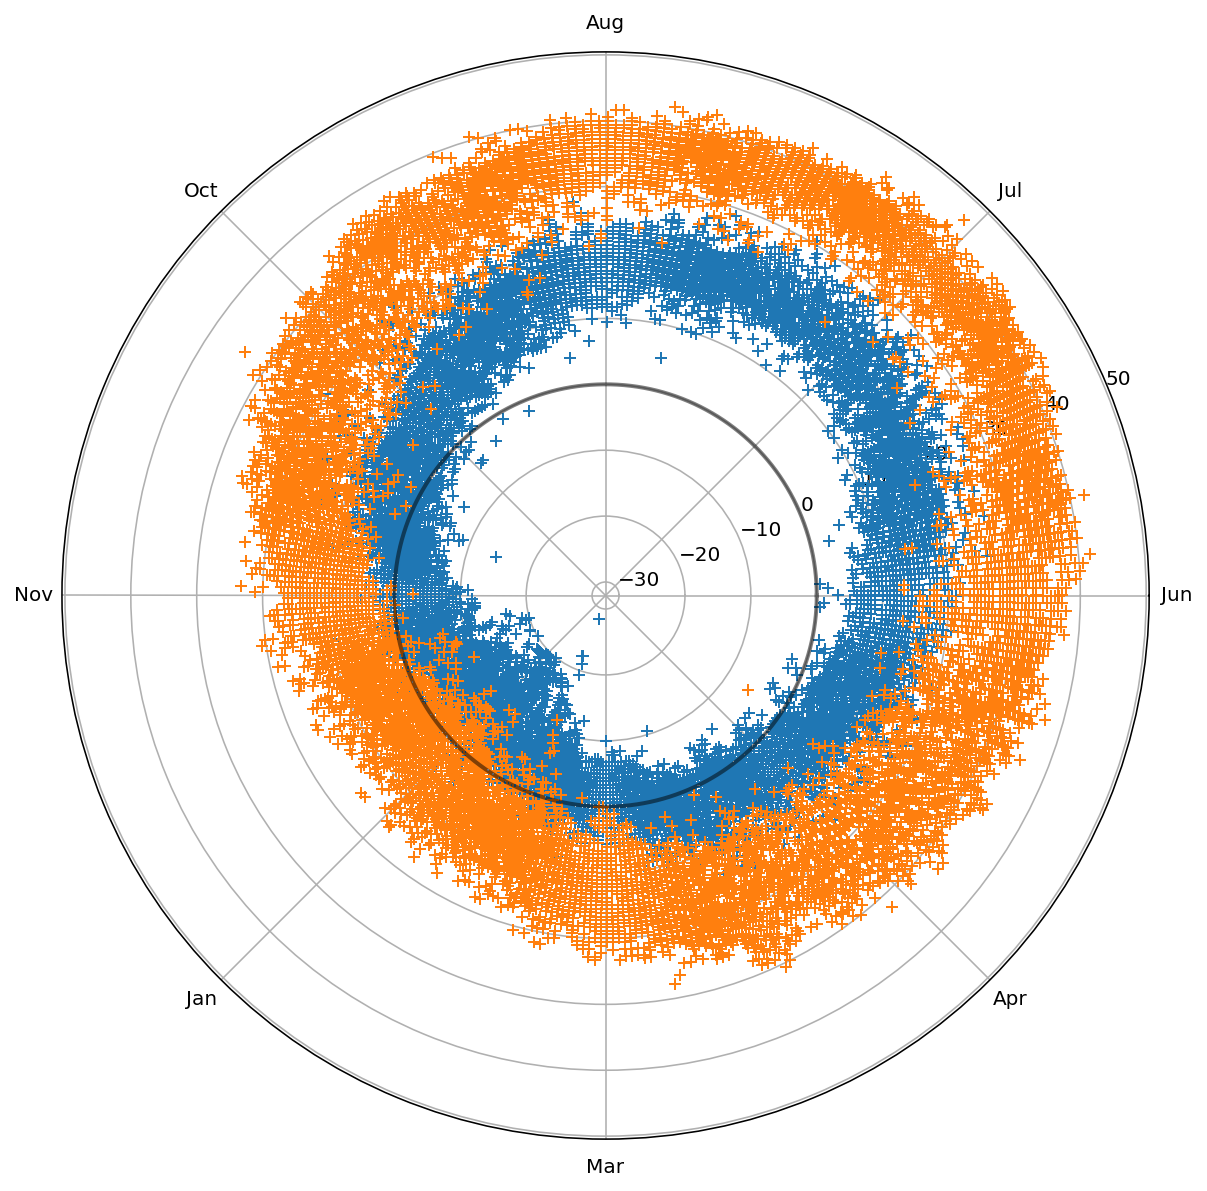

In [3]:
years = np.asarray((data.DATE - data.DATE[0])/pd.to_timedelta('365Day'))

dt = data.TMAX - data.TMIN

offset = dt.max()*years

fmt = fmt_month = MyDateFormatter('%b')
fmt_day = MyDateFormatter('%d')

plt.figure(figsize=(10,10))
ax = plt.axes(polar=True)
ax.plot(fmt_month.date_to_theta(data.DATE), data.TMIN, '+')
ax.plot(fmt_month.date_to_theta(data.DATE), data.TMAX, '+')
ax.xaxis.set_major_formatter(fmt_month)
th = np.linspace(0, 2*np.pi, 200)
ax.plot(th, 0*th, '-k', lw=2, alpha=0.5)
#ax.xaxis.set_minor_formatter(fmt_day)
#ax.xaxis.set_ticks(fmt.date_to_theta([pd.to_timedelta('1Day') for _N in range(365)]))
#ax.xaxis.set_ticks(['])
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
#ax.fill_between(2*np.pi * years, data.TMIN, data.TMAX, '+')
#DateFormatter

Part of the problem with this data is that it is incomplete.  We start by simply matching a sine-wave $\cos(\omega t + \phi) = \cos(\omega t)\cos\phi - \sin(\omega t)\sin \phi$.  Let $\ket{c} = \cos(\omega t)$, $\ket{s} = \sin(\omega t)$, and $\ket{f} = s(t)$ be our signal.  We want to minimize over the phase $\phi$ the norm:

$$
  \min_{\phi} \norm{\ket{f} - \ket{c}\cos\phi + \ket{s}\sin\phi}^2.
$$

To do this, we introduce an orthonormal basis $\ket{c'}$ and $\ket{s'}$ with Gram-Schmidt:

$$
  \ket{c'} = \frac{\ket{c}}{\sqrt{\braket{c|c}}}, \qquad
  \ket{s'} \propto \ket{s} - \ket{c'}\braket{c'|s}.
$$

This can be easily done numerically with a QR decomposition:

$$
  \begin{pmatrix}
    \ket{c} &
    \ket{s}
  \end{pmatrix}
  =
  \overbrace{
  \begin{pmatrix}
    \ket{c'} &
    \ket{s'}
  \end{pmatrix}
  }^{\mat{Q}}
  \mat{R}
$$

Our minimization problem now becomes a minimization over unit vectors $\ket{\phi} = (\cos\phi, -\sin\phi)$:

$$
  \min_{\ket{\phi}} \Bigl\lVert 
  \ket{f} - \mat{Q}\mat{R}\ket{\phi}
  \Bigr\rVert^2
  =
  \norm{f}^2 + \min_{\ket{\phi}}\left(
    \braket{\phi|\mat{R}^T\mat{R}|\phi} 
    - 2\braket{f|\mat{Q}\mat{R}|\phi}\right), \qquad
  \braket{\phi|\phi} = 1,\\
  \mat{R}\ket{\phi} \propto 2\mat{Q}^T\ket{f}.
$$

In [342]:
from IPython.display import clear_output
%pylab inline
import pandas as pd

datafile = '2478833.csv'
data = pd.read_csv(datafile, quotechar='"', parse_dates=[2])

s = np.ma.masked_invalid(data.TMIN)   # Start with the minimum temperatures
t = data.DATE
t0 = t[0]
days = np.asarray((t - t0)/pd.to_timedelta('1Day'), dtype=int)

s_, days_ = map(np.asarray, (s[s.mask == False], days[s.mask == False]))

Populating the interactive namespace from numpy and matplotlib


/ext/anaconda2020.02/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['s_']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [343]:
def get_phi(T, f, t=days_):
    """Return (a, A, phi) such that f(t) ~ A*cos(2*pi t/T + phi)."""
    N = len(t)
    w = 2*np.pi/T
    cs = np.exp(1j*w*t).view(dtype=float).reshape((N, 2))
    Q, R = np.linalg.qr(cs)
    assert Q.shape == (N, 2)
    assert R.shape == (2,2)
    phi = np.linalg.solve(R, 2*Q.T @ f)
    phi /= np.linalg.norm(phi)
    psi = cs @ phi
    phi = np.arctan2(-phi[1], phi[0])
    psi_norm = np.linalg.norm(psi)
    a = psi @ f / psi_norm
    A = a / psi_norm
    return (a, A, phi)

get_phi(10.0, np.cos(2*np.pi * days_/10.0 + 0.1), days_)

(85.34248567177019, 1.0000000000000002, 0.10000000000017353)

Above we write a function which returns the best match $A$ and $\phi$ for a given period $T$:

$$
  f(t) \approx A\cos\left(\frac{2\pi t}{T} + \phi\right) = a d_T(t)
$$

where $d_T(t) \propto \cos\left(\frac{2\pi t}{T} + \phi\right)$ is an entry in our dictionary normalized by the factor $a/A$ so that the discrete $L_2$ norm is unity.  The coefficient $a$ thus the overlap of our signal with the dictionary entry $d_T$.  We use this to compute the residual, and define a function to maximize this with a local minimization algorithm from SciPy.

In [344]:
from scipy.optimize import minimize_scalar
from cycles.cycles import orthogonal_matching_pursuit

def residual(T, f, t=days_):
    return get_phi(T, f=f, t=t)[0]

def get_max(f, bracket=[1, 366], t=days_):
    res = minimize_scalar(lambda T: -residual(T, f=f, t=t), bracket=bracket)
    if not res.success:
        print(res.message)
    return res.x

#print(residual(10.0, np.cos(2*np.pi * days_/10.0 + np.pi/2), days_))
N_df = 3
inds = slice(0, 365*2)
t = days_[inds]
s = s_[inds]
get_max(T, [360, 370], t)
f_max = 0.5/np.diff(t).min()
df = 1/(t.max() - t.min()) / N_df
Nf = np.ceil(f_max/df)
df = f_max / Nf
fs = np.arange(1, Nf)*df

def match(r, t=t, fs=fs):
    res = [residual(1/_f, r0, t) for _f in fs]
    ind = np.argmax(res)
    bracket = [1/fs[ind+1], 1/fs[ind-1]]
    T0 = get_max(r, bracket=bracket, t=t)
    (a, A, phi) = get_phi(T0, f=r, t=t)
    d = np.cos(2*np.pi * t / T0 + phi)
    d /= np.linalg.norm(d)
    return (a, d, (A, T0, phi))

r0 = s - s.mean()
res = orthogonal_matching_pursuit(r0, match, max_rank=1)
#plt.semilogx(fs, res)

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [340]:
a, d, (A, T, phi) = match(r0)
r1 = r0 - A*np.cos(2*np.pi * t / T + phi)
match(r1)[0]

29.071720333736113

Now let's explore the data a bit.  We start with a routine that will plot the residuals on a semi-log plot.

In [298]:
def plot_residuals(f, Tmin=0.5, Tmax=2*days_.max(), Nt=1000, t=days_, 
                   ax=None, xticks=True, **kw):
    Ts = 10**np.linspace(np.log10(Tmin), np.log10(Tmax), Nt)
    res = [residual(_T, f=f, t=t) for _T in Ts]
    if ax is None:
        ax = plt.gca()
    ax.plot(Ts, res, **kw)
    ax.set(ylabel='residual', xlabel='period T [days]')
    if xticks is True:
        ax.set(xticks=[1.0, 365, 10*365], 
               xticklabels=['1d', '1y', '10y'])

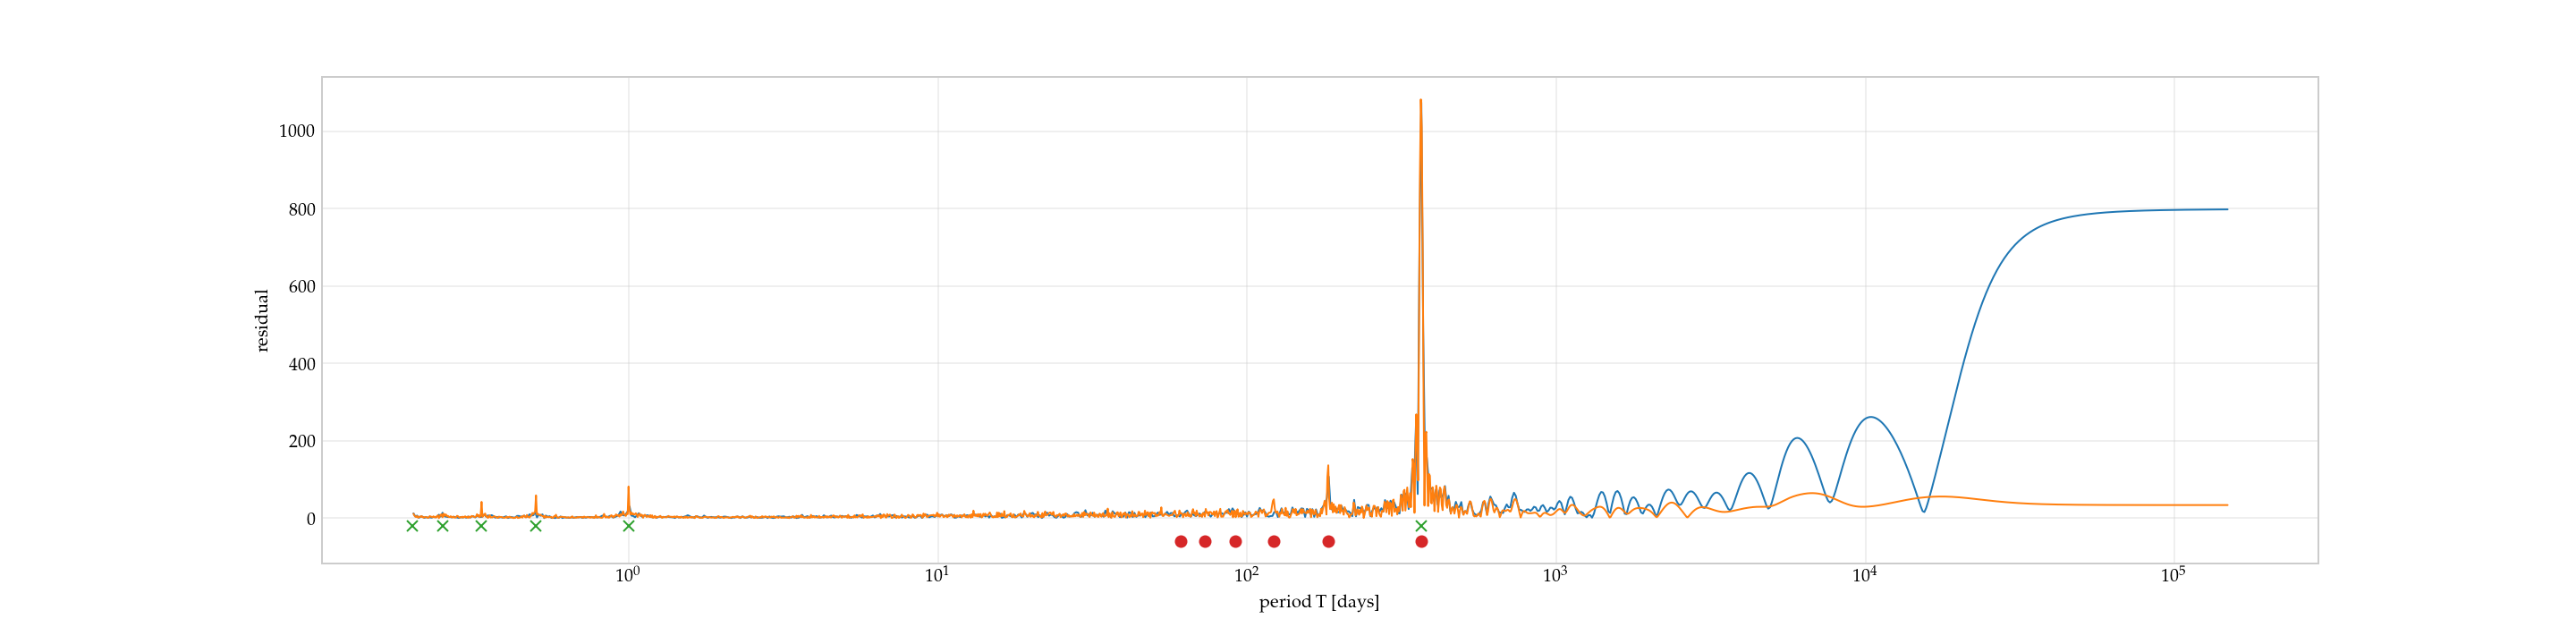

In [299]:
plt.figure(figsize=(20,5))
args = dict(Tmin=0.201, Tmax=10*days_.max())
plot_residuals(s_, **args)
r0 = s_ - s_.mean()
plot_residuals(r0, Nt=2000, **args)
m = np.arange(6)
dt = 1.0     # Daily sample interval
T0 = 365.0   # Yearly cycle
Tm = 1/(1/T0 + m/dt)
plt.semilogx(Tm, 0*Tm-20, 'x')
plt.semilogx(T0/(1+m), 0*Tm-60, 'o')

We notice a few things:

1. There is a large residual for very long periods $T \rightarrow \infty$.  This corresponds to a zero-frequency component $\cos(0t+\phi)$ which is a constant offset.  We can remove this by subtracting the mean temperature as we show above in orange.  In some cases, one might also want to remove a linear or exponential trend to aid in seeing cycles, however, this can bias your results.  For example, we might hypothesize that such a trend could be caused by global warming.  However, we shall see that a much larger trend will be introduce by the overall sampling period and removing this will introduce errors in our extraction of cycle frequencies.
2. There is a large peak near 1 year.  This is obviously expected for temperature data.  We will extract this feature first.
3. There are repeated peaks at lower periods.  These arise from the fact that the data is sampled at a uniform interval of $\delta t = 1$day.  This means that frequencies differing by $\delta \omega = 2\pi m /\delta t$ where $m$ is an integer, are indistinguishable.  These peaks are called "aliasing" artifacts, and occur at periods:

   $$
      T_m = \frac{1}{\frac{1}{T_0} + \frac{m}{\delta t}}
   $$
   
   We show these as small crosses in the plot above.
4. There are also features at $T_m = T_0/m$ where $m$ is an integer shown as red dots above.  These are expected as part of the harmonic series of periodic signals that are not purely sinusoidal.  Although there is a definite yearly cycle, there is no reason to expect that the fluctuations are exactly sinusoidal.

We now focus on extracting the yearly cycle:

AttributeError: 'IndexExpression' object has no attribute 'mean'

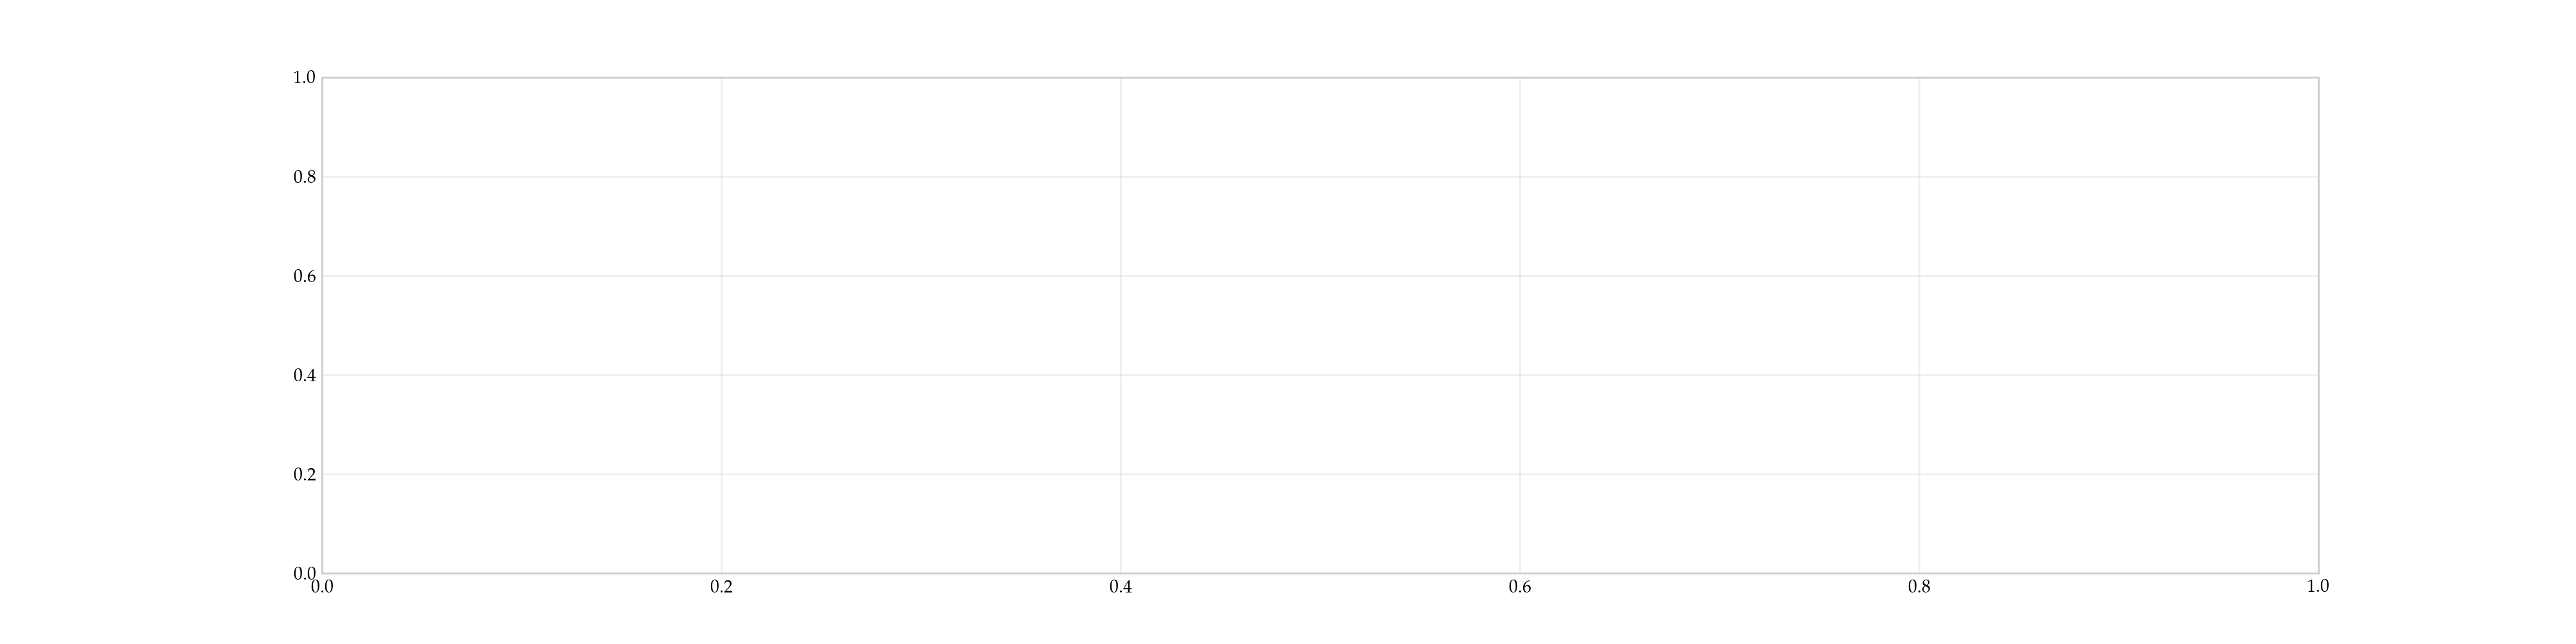

In [294]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
args = dict(Tmin=345, Tmax=385, xticks=False, ax=ax)
r0 = s_ - s_.mean()
T0 = get_max(f=r0, bracket=[360, 370])
(a0, A0, phi0) = get_phi(T0, f=r0)
r1 = r0 - A0*np.cos(2*np.pi * days_ / T0 + phi0)
plot_residuals(r0, **args)
plot_residuals(r1, **args)
plt.axvline([T0])
w0 = 2*np.pi/T0
Tmax = days_.max() - days_.min()
dT0 = T0**2/Tmax
plt.axvline([T0])
plt.axvline([T0+dT0], c='y', ls=':')
plt.axvline([T0-dT0], c='y', ls=':')
plt.title(f"T0={T0:.4f}days");
Ts = np.linspace(args['Tmin'], args['Tmax'], 1000)
ws = (2*np.pi/Ts - w0)

# Numpy sinc has an additional pi which we must remove.
plt.plot(Ts, abs(np.sinc(Tmax*ws/2/np.pi))*1000, c='y', ls='--')

Here we have found that the main period is $365.22$ days.  To compare, the [tropical year](https://en.wikipedia.org/wiki/Tropical_year) is $365.24219$ days and the [sidereal year](https://en.wikipedia.org/wiki/Sidereal_year) is $365.25636$ days.  It is unlikely we have the precision within this data set to resolve these: a careful error analysis is needed, but we are very close.

Another important feature of this plot is the width of the fluctuating features.  This is given by the general overlap between sine functions.  For an estimate, consider two pure sine waves integrated from $t=0$ to  $t=T$:

$$
  \DeclareMathOperator{\sinc}{sinc}
  \min_{\phi} \int_{-T/2}^{T/2}\d{t} \cos(\omega t)\cos(\omega_0 t + \phi) = 
  \frac{T^2}{4}\left(
    \sinc\frac{T\omega_+}{2}
    + \sinc\frac{T\omega_-}{2}
  \right)^2.
$$

This function is shown above as a dashed yellow line (scaled vertically by hand to fit the data).  The function $\sinc\theta$ has roots at $\theta = \pm \pi$ corresponding to a resolution of

$$
  \omega \sim \omega_0 \pm \frac{2\pi}{T_\max}, \qquad
  T \sim \frac{2\pi}{\omega_0 \pm \frac{2\pi}{T_\max}} 
    \sim  T_0 \pm \frac{T_0^2 }{T_\max}.
$$

We show these limits above as a dotted yellow lines.

*(Still playing below)*

In [0]:
r0 = s_ - s_.mean()
T0 = get_max(f=r0, bracket=[360, 370])
print(T0)
(a0, A0, phi0) = get_phi(T0, f=r0)
r1 = r0 - A0*np.cos(2*np.pi * days_ / T0 + phi0)
T1 = get_max(f=r1, bracket=[360/2, 368/2])
print(2*T1)
(a1, A1, phi1) = get_phi(T1, f=r1)
r2 = r1 - A1*np.cos(2*np.pi * days_ / T1 + phi1)
T2 = get_max(f=r2, bracket=[363/3, 366/3])
print(3*T2)
(a2, A2, phi2) = get_phi(T2, f=r2)
r3 = r2 - A2*np.cos(2*np.pi * days_ / T2 + phi2)

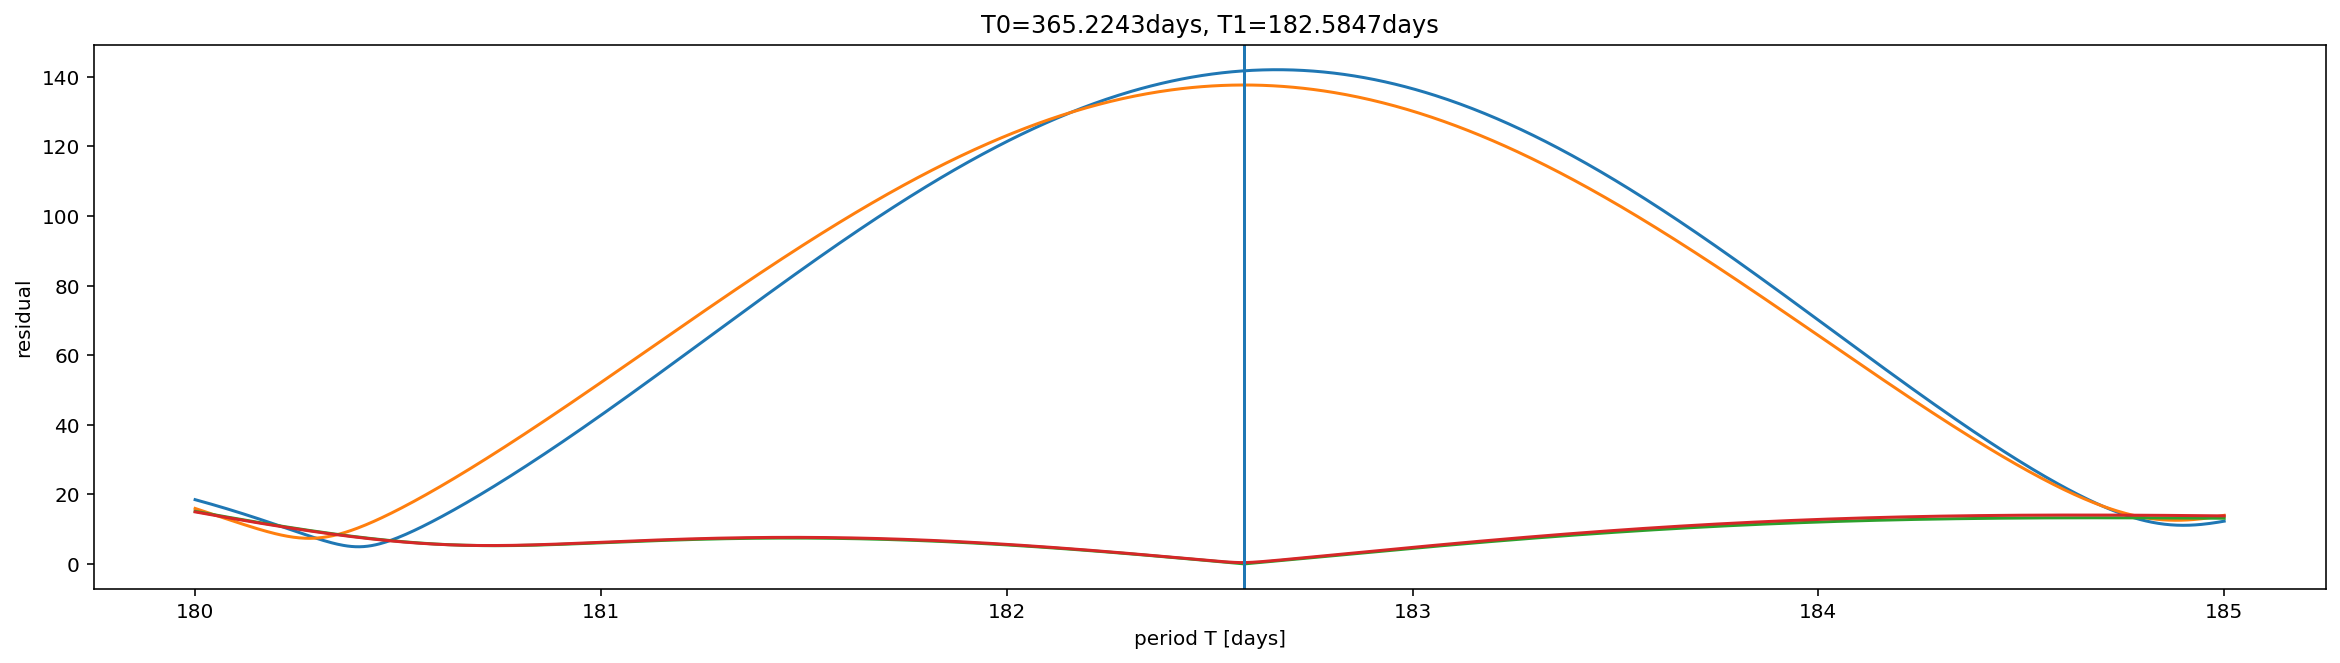

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
args = dict(xticks=False, ax=ax)
#plot_residuals(r0, Tmin=345, Tmax=385, **args)
#plot_residuals(r1, Tmin=345, Tmax=385, **args)
#plot_residuals(r2, Tmin=345, Tmax=385, **args)
#plot_residuals(r3, Tmin=345, Tmax=385, **args)
#plot_residuals(r2, Tmin=360/3, Tmax=370/3, **args)
#plot_residuals(r3, Tmin=360/3, Tmax=370/3, **args)
#plt.axvline([T0])
#plt.axvline([T2])

plt.title(f"T0={T0:.4f}days, T1={T1:.4f}days");


In [0]:
plot_residuals(r0, Tmin=360/2, Tmax=370/2, **args)
plot_residuals(r1, Tmin=360/2, Tmax=370/2, **args)
plot_residuals(r2, Tmin=360/2, Tmax=370/2, **args)
plot_residuals(r3, Tmin=360/2, Tmax=370/2, **args)
plt.axvline([T1])

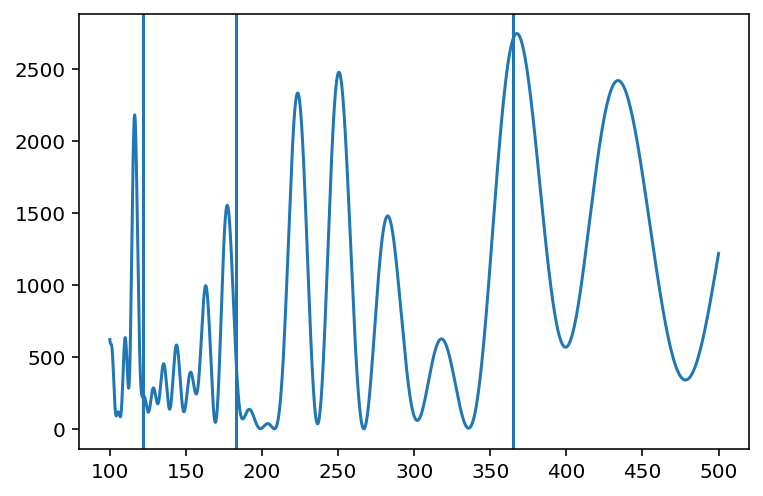

In [31]:
from scipy.signal import lombscargle
import numpy as np
fs = np.linspace(0.01, 1/500, 5000)
plt.plot(1./fs, lombscargle(days_, s_, fs))
plt.axvline([365.25])
plt.axvline([365.25/2])
plt.axvline([365.25/3])

In [32]:
from scipy.optimize import leastsq

def unpack(q):
    A0 = q[0]
    N = len(q) - 1
    As, fs, phis = np.reshape(q[1:], (3, N//3))
    return A0, As, fs, phis

def pack(A0, As, fs, phis):
    return np.array([A0] + np.ravel([As, fs, phis]).tolist())

def residuals(q):
    A0, As, fs, phis = unpack(q)
    return A0 + sum(A*np.cos(2*np.pi*f*days_ + phi)
                    for A, f, phi in zip(As, fs, phis)) - s_

def get_q(Ts, s_):
    A0 = s_.mean()
    As = []
    fs = []
    phis = []
    for T in Ts:
        a, A, phi = get_phi(T, s_ - A0)
        As.append(A)
        fs.append(1/T)
        phis.append(phi)
    return pack(A0, As, fs, phis)

q0 = get_q([365.25, 365.16/2, 364.78/3, 365.02/4.0], s_)
q, succ = leastsq(residuals, q0, full_output=False)
assert succ == 1
A0, As, fs, phis = unpack(q)
Ts = 1/fs
print(Ts*[1,2,3,4])

/ext/anaconda2020.02/lib/python3.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[365.22806921 365.1645749  364.78557806 365.01513123]


In [0]:
182.58

In [0]:
Ts = np.linspace(365.2, 365.3, 1000)
T_tropical_year = 365.24219
T0 = get_max(s_, bracket=[360 , 370])
res = [residual(_T, s_) for _T in Ts]
plt.plot(Ts, res)
plt.axvline([T_tropical_year], c='y')
plt.axvline([T0], c='g')

In [0]:
Ts = 10**np.linspace(-0.5, np.log10(days_.max())+1, 2000)
# Detrend
f0 = s_ - np.polyval(np.polyfit(days_, s_, deg=0), days_)
res0 = [residual(_T, f0) for _T in Ts]
T0 = get_max(f0, bracket=[360 , 370])
a0, A0, phi0 = get_phi(T0, f=f0, t=days_)
f1 = f0 - A0*np.cos(2*np.pi * days_/T0 + phi0)
res1 = [residual(_T, f=f1) for _T in Ts]
T1 = get_max(f1, bracket=[182, 185])
a1, A1, phi1 = get_phi(T1, f=f1, t=days_)
f2 = f1 - A1*np.cos(2*np.pi * days_/T1 - phi1)
res2 = [residual(_T, f=f2) for _T in Ts]

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.semilogx(Ts, res0)
ax.loglog(Ts, res1, alpha=0.5)
ax.loglog(Ts, res2, alpha=0.5)
dt = 1.0
ms = np.arange(3)
Tms = 1/(1/T0 + ms/dt)
ax.set(xticks=Tms.tolist() + [1.0, 365, 10*365], 
       xticklabels=ms.tolist() + ['1d', '1y', '10y']);

In [0]:
Ts = np.linspace(170, 190, 100)
res1 = [residual(_T, f=f1) for _T in Ts]
a1, A1, phi1 = get_phi(T1, f=f1)
residual(T1, f1 + A1*np.cos(2*np.pi * days_/T1 + phi1))

In [0]:
A1, phi1, 

In [0]:
T0/2, T1

In [0]:
from ipywidgets import interact

@interact(f=(-3.0, 3.0))
def go(f=1.0):
    f2 = f1 - f*A1*np.cos(2*np.pi * days_/T1 + phi1)
    res2 = [residual(_T, f=f2) for _T in Ts]
    plt.plot(Ts, res1)
    plt.plot(Ts, res2)
    plt.axvline([T1])

In [0]:
fig, axs = plt.subplots(3, 1, figsize=(20,5))
Ts = np.linspace(300, 400, 1000)
res = [residual(_T, f0) for _T in Ts]
axs[0].plot(Ts, res)
axs[0].axvline([T0], c='y')

Ts = np.linspace(150, 200, 1000)
res = [residual(_T, f1) for _T in Ts]
axs[1].plot(Ts, res)
axs[1].axvline([T1], c='y')

Ts = np.linspace(150, 200, 1000)
res = [residual(_T, f2) for _T in Ts]
axs[1].plot(Ts, res)
#axs[2].axvline([T2], c='y')

In [0]:
np.cos(1.02 + np.pi/2), -np.sin(1.02)

Note that if we have a sampling interval of $\delta t$, then frequencies are indistinguishable

$$
  \omega' \equiv \omega \mod \frac{\pi}{\delta t}
$$

since 

$$
  \cos(\omega' n \delta t) = \cos(\omega n \delta t + \pi) = - \cos(\omega n \delta t).
$$


Thus, the maximum frequency we need to consider is:

$$
  f_\max = \frac{1}{2\delta t}.
$$

$$
  w_m = w + 2*pi*m/n/a
$$

In [0]:
def match_exact(s):
    T = minimize_scalar(lambda T: -residual(T, days_, s), bracket=[360 , 370])
    

In [0]:
from IPython.display import clear_output
%pylab inline
import pandas as pd

datafile = '2478833.csv'
data = pd.read_csv(datafile, quotechar='"', parse_dates=[2])

s = np.ma.masked_invalid(data.TMIN)   # Start with the minimum temperatures
t = data.DATE
t0 = t[0]
days = np.asarray((t - t0)/pd.to_timedelta('1Day'), dtype=int)

s_, days_ = map(np.asarray, (s[s.mask == False], days[s.mask == False]))

def f(T):
    e = np.exp(2j*np.pi * days_ / T)
    return e.dot(s_)

f(365)


  This makes it nontrivial to work with for period finding.  Here we implement the matching-pursuit algorithm to find the cycles.

In [0]:
from IPython.display import clear_output
%pylab inline
import pandas as pd

datafile = '2478833.csv'
data = pd.read_csv(datafile, quotechar='"', parse_dates=[2])

s = np.ma.masked_invalid(data.TMIN)   # Start with the minimum temperatures
t = data.DATE
t0 = t[0]
days = np.asarray((t - t0)/pd.to_timedelta('1Day'), dtype=int)

s_, days_ = map(np.asarray, (s[s.mask == False], days[s.mask == False]))

# Limit data size for now
inds = slice(0, 356*2)
s, days = s_[inds], days_[inds]

# Now look for cycles with the following periods
N = 20000        # Don't make this too big... use Dask maybe?
T_min = 0.99     # Don't make this an exact number of days or aliasing will give zero vectors.
T_max = days.max()
Ts = np.linspace(T_min, T_max, N)
ws = 2*np.pi / Ts
D_ = np.exp(1j*ws[np.newaxis, :] * days[:, np.newaxis])
D = D_.view(dtype=float)
Dc = D[:, ::2]
Ds = D[:, 1::2]
assert np.allclose(D_.real, Dc)
assert np.allclose(D_.imag, Ds)
norms = np.linalg.norm(D, ord=2, axis=0)
D /= norms

assert np.allclose([np.linalg.norm(d) for d in D.T], 1)

def match_1(s):
    """Return best match `(d, (A, w, phase))`.

    This is a raw match: sines and cosines are in the same dictionary.

    Returns
    -------
    d : array
       Normalized best match
    (A, w, phase) : float
       Matching function is `A*cos(w*t + phase)`
    """
    a_ = s @ D
    i = np.argmax(a_)
    a = a_[i]
    d = D[:, i]
    A, w = 1/norms[i], ws[i//2]
    phase = 0
    if i % 2:  # Odd i means sine:
        phase = -np.pi/2
    assert np.allclose(np.linalg.norm(d), 1)
    assert np.allclose(d, A*np.cos(w*days + phase))
    return d, a, (A, w, phase)

match_1(s)

def match_2(s):
    """Pair matching - best match with phase.

    Returns
    -------
    d : array
       Normalized best match
    a : float
       Coefficient of overlap.
    (w, phase) : float
       Matching function is `a*cos(w*t + phase) = a[0]*sin(w*t) + a[1]*cos(2*t)`.
    """
    # Even indices
    a_ = s @ D
    i = np.argmax(a_)
    i_ = i // 2
    w = ws[i_]
    i_cos = 2 * i_
    i_sin = i_cos + 1

    ds = D[:, i_cos:i_cos+2]
    a_ = (ds.T @ s)
    d = ds @ a_
    d_norm = np.linalg.norm(d)
    d /= d_norm
    a = d @ s
    a_ /= (d_norm*norms[i_cos:i_cos+2])
    A = np.linalg.norm(a_)
    phase = np.arctan2(-a_[1], a_[0])
    assert np.allclose(d, A*np.cos(w*days + phase))
    return d, a, (A, w, phase)

d, a, (A, w, phi) = match_2(1+0*s)
#plt.plot(days, d)
#plt.plot(days, a*A*np.cos(w*days + phi))
#plt.plot(days, Ds[:, 0])
#plt.plot(days, Ds[:, 2])

The goal here is to find a low-dimensional approximation of a signal $\vect{s}$:

$$
  \vect{s} \approx \sum_{j} \vect{d}_j \alpha_{j}.
$$


We shall use the following notation in the algorithm.  Let $\vect{s}_j$ be the $j$th approximation and $\vect{r}_j = \vect{s} - \vect{s}_j$ be the corresponding residual:

   $$
     \vect{s}_{j} = \sum_{i=0}^{j-1} \vect{d}_i \alpha_i = \vect{s} - \vect{r}_j.
   $$

The Matching Pursuit algorithm is:

1. Prepare your dictionary as a map from residuals $\vect{r}$ to normalized vectors $\vect{d}$ which are the best match in the sense of maximizing the overlap $\abs{\braket{\vect{d}, \vect{r}}}$:

   $$
     \DeclareMathOperator{\match}{match}
     \DeclareMathOperator*{\argmax}{argmax}
     \vect{d} = \match(\vect{r}) = \argmax_{\norm{\vect{d}}_{2} = 1}\abs{\braket{\vect{d}, \vect{r}}}.
   $$

   *(If the dictionary is stored in a matrix of columns $\mat{D} = [\vect{d}_0, \vect{d}_1, \cdots]$, then this would be implemented as:*

   $$
     \DeclareMathOperator*{\argmax}{argmax}
     i = \argmax_{i}\abs{\braket{\vect{d}_i, \vect{r}}}, \qquad D(\vect{r}) = \vect{d}_{i}.
   $$
   
   *If the dictionary is large, then this computation could be done in parallel, or using hardward acceleration like a GPU.)*

2. Choose a relative stopping criterion $\epsilon < 1$.  I.e. $\epsilon = 0.05 = 5\%$.
3. Start with residual $\vect{r}_0 = \vect{s}$ and iterate until $\norm{\vect{r}_j}_2 < \epsilon\norm{\vect{s}}_2$ *(or some maximum rank is reached)*:

   \begin{align}
     \DeclareMathOperator{\match}{match}
     \vect{d}_j &= \match(\vect{r}_j), \\
     \alpha_j &= \braket{\vect{d}_j,\vect{r}_j}, \\
     \vect{r}_{j+1} &= \vect{r}_j - \vect{d}_{j}\alpha_j.
   \end{align}

In [0]:
from cycles.cycles import matching_pursuit, orthogonal_matching_pursuit

$$
  a_0\cos(\omega t) + a_1\sin(\omega t) 
  = A\cos(\omega t + \phi)
  = A\cos(\omega t)\cos\phi - A\sin(\omega t)\sin\phi,\\
  a_0 = A\cos\phi, \qquad
  a_1 = -A\sin\phi, \\
  A = \sqrt{a_0^2 + a_1^2}, \qquad
  \phi = \tan^{-1}\frac{-a_1}{a_0}.
$$

In [0]:
max_rank2 = 100
D1, a1, f1, r1 = matching_pursuit(s, match=match_1, max_rank=2*max_rank2)
D2, a2, f2, r2 = matching_pursuit(s, match=match_2, max_rank=max_rank2)
D1o, a1o, f1o, r1o = orthogonal_matching_pursuit(s, match=match_1, max_rank=2*max_rank2)
D2o, a2o, f2o, r2o = orthogonal_matching_pursuit(s, match=match_2, max_rank=max_rank2)

In [0]:
N = 100
a, f = a2o, f2o
plt.plot(days_, s_ - sum(_a*_A*np.cos(_w*days_ + _phi) for (_a, (_A, _w, _phi)) in zip(a[:N], f[:N])))

In [0]:
plt.figure(figsize=(20,10))
plt.plot(days, s)

In [0]:
rank1 = np.arange(len(r1))/2
rank2 = np.arange(len(r2))
l1, l2 = plt.semilogy(rank1, r1, rank2, r2)

rank1 = np.arange(len(r1o))/2
rank2 = np.arange(len(r2o))
plt.semilogy(rank1, r1o, '--', c=l1.get_c())
plt.semilogy(rank2, r2o, '--', c=l2.get_c())

The orthogonal-matching-pursuit algorithm has similar convergence behaviour for both exact period matching an inexact, unlike the regular.